In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import os
from matplotlib import pyplot as plt

## (Optional) Prepare a smaller dataset for your experiment

* python example: `tutorials/subsamples.py`
* api: `utils.data.subsampling`

In [14]:
from utils.data import subsampling
from utils.file import load_from_json

# load the configurations for the experiment
data_configs = load_from_json("../src/configs/task1/data-mnist.json")
output_root = "../results"

# load the full-sized benign samples
file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
X_bs = np.load(file)

# load the corresponding true labels
file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
labels = np.load(file)

# get random subsamples
# for MNIST, num_classes is 10
# files "subsamples-mnist-ratio_0.1-xxxxxx.npy" and "sublabels-mnist-ratio_0.1-xxxxxx.npy"
# will be generated and saved at "/results" folder, where "xxxxxx" are timestamps.

subsamples, sublabels = subsampling(data=X_bs,
                                    labels=labels,
                                    num_classes=10,
                                    filepath=output_root,
                                    filename='mnist')

## Update the json file accordingly

1. Copy and paste the generated subsamples to the right place (i.e., defined by `"dir"` in `data-mnist.json`).
2. In the `data-mnist.json`, replace the value of `"bs_file"` with the `"subsamples-mnist-ratio_0.1-xxxxxx.npy"` and the value of `"label_file"` with the `"sublabels-mnist-ratio_0.1-xxxxxx.npy"`.

# Generate adversarial examples
We use `FGSM` as the example.
* python example: `tutorials/craft_adversarial_examples.py`
* main api: `attacks.attack.generate`
* check tunable parameters for each attack in file `attacks/attack.py`.

In [27]:
# copied from tutorials/craft_adversarial_examples.py
def generate_ae(model, data, labels, attack_configs, save=False, output_dir=None):
    """
    Generate adversarial examples
    :param model: WeakDefense. The targeted model.
    :param data: array. The benign samples to generate adversarial for.
    :param labels: array or list. The true labels.
    :param attack_configs: dictionary. Attacks and corresponding settings.
    :param save: boolean. True, if save the adversarial examples.
    :param output_dir: str or path. Location to save the adversarial examples.
        It cannot be None when save is True.
    :return:
    """
    img_rows, img_cols = data.shape[1], data.shape[2]
    num_attacks = attack_configs.get("num_attacks")
    data_loader = (data, labels)

    if len(labels.shape) > 1:
        labels = np.asarray([np.argmax(p) for p in labels])

    # generate attacks one by one
    for id in range(num_attacks):
        key = "configs{}".format(id)
        data_adv = generate(model=model,
                            data_loader=data_loader,
                            attack_args=attack_configs.get(key)
                            )
        # predict the adversarial examples
        predictions = model.predict(data_adv)
        predictions = np.asarray([np.argmax(p) for p in predictions])

        err = error_rate(y_pred=predictions, y_true=labels)
        print(">>> error rate:", err)

        # plotting some examples
        num_plotting = min(data.shape[0], 2)
        for i in range(num_plotting):
            img = data_adv[i].reshape((img_rows, img_cols))
            plt.imshow(img, cmap='gray')
            title = '{}: {}->{}'.format(attack_configs.get(key).get("description"),
                                        labels[i],
                                        predictions[i]
                                        )
            plt.title(title)
            plt.show()
            plt.close()

        # save the adversarial example
        if save:
            if output_dir is None:
                raise ValueError("Cannot save images to a none path.")
            # save with a random name
            file = os.path.join(output_dir,
                "AE-mnist-cnn-clean-spatial_mxtrans{}_nmtrans{}_mxrot{}_nmrot{}.npy".format(
                    attack_configs.get(key).get("max_translation"),
                    attack_configs.get(key).get("num_translations"),
                    attack_configs.get(key).get("max_rotation"),
                    attack_configs.get(key).get("num_rotations"))
                )
            print("Save the adversarial examples to file [{}].".format(file))
            np.save(file, data_adv)

>>> Loading model [../models/cnn/model-mnist-cnn-clean.h5]...
>>> error rate: 0.155


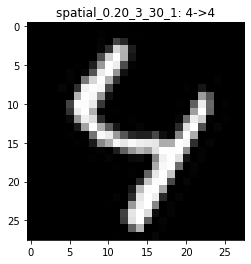

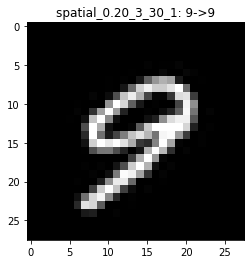

Save the adversarial examples to file [../results\AE-mnist-cnn-clean-spatial_mxtrans0.2_nmtrans3_mxrot30_nmrot1.npy].
>>> error rate: 0.155


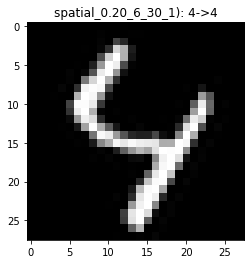

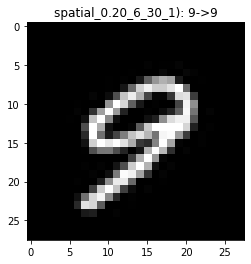

Save the adversarial examples to file [../results\AE-mnist-cnn-clean-spatial_mxtrans0.2_nmtrans6_mxrot30_nmrot1.npy].
>>> error rate: 0.155


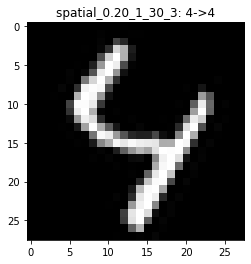

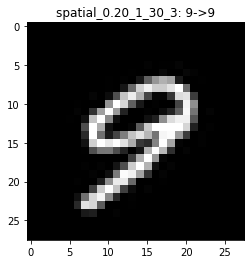

Save the adversarial examples to file [../results\AE-mnist-cnn-clean-spatial_mxtrans0.2_nmtrans1_mxrot30_nmrot3.npy].
>>> error rate: 0.155


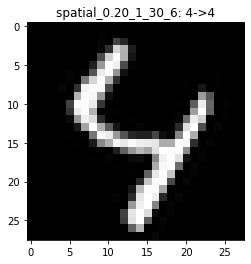

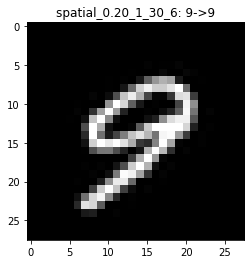

Save the adversarial examples to file [../results\AE-mnist-cnn-clean-spatial_mxtrans0.2_nmtrans1_mxrot30_nmrot6.npy].
>>> error rate: 0.155


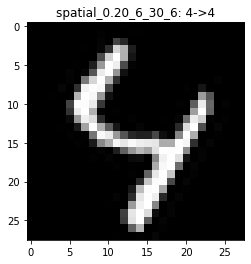

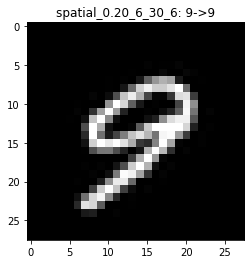

Save the adversarial examples to file [../results\AE-mnist-cnn-clean-spatial_mxtrans0.2_nmtrans6_mxrot30_nmrot6.npy].


In [28]:
from utils.model import load_lenet
from utils.metrics import error_rate
from attacks.attack import generate
from utils.file import load_from_json

# loading experiment configurations
model_configs = load_from_json("../src/configs/task1/model-mnist.json")
data_configs = load_from_json("../src/configs/task1/data-mnist.json")
attack_configs = load_from_json("../src/configs/task1/attack-spatial-mnist.json")

# load the targeted model
model_file = os.path.join(model_configs.get("dir"), model_configs.get("um_file"))
target = load_lenet(file=model_file, wrap=True)

# load the benign samples

data_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
data_bs = np.load(data_file)
# load the corresponding true labels
label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
labels = np.load(label_file)

# generate AEs
# in this example, we generate AEs for 5 benign samples
# data_bs = data_bs[:5]
# labels = labels[:5]
# let save=True and specify an output folder to save the generated AEs
generate_ae(model=target, data=data_bs, labels=labels, attack_configs=attack_configs, save=True, output_dir="../results")

## Update the generated adversarial examples in json

* Either add an item for the generated AEs. e.g., assume that we named the generated AE as `"fgsm_eps0.3.npy"`, then add the item as below example, then get your AE list by `data_configs.get("task1_aes")`.

```
"task1_aes" : [
                  "fgsm_eps0.3.npy"
              ]

```


2. Or, create a new json file similar to `"data-mnist.json"`, and replace the whole list for `"ae_files"` with your own list.

# Evaluate the generated AEs
* python example: `tutorials/eval_model.py`
* api: `utils.metrics.error_rate`

In [5]:
from utils.model import load_pool
from utils.metrics import error_rate, get_corrections
from models.athena import Ensemble, ENSEMBLE_STRATEGY

# copied from tutorials/eval_model.py
def evaluate(trans_configs, model_configs,
             data_configs, save=False, output_dir=None):
    """
    Apply transformation(s) on images.
    :param trans_configs: dictionary. The collection of the parameterized transformations to test.
        in the form of
        { configsx: {
            param: value,
            }
        }
        The key of a configuration is 'configs'x, where 'x' is the id of corresponding weak defense.
    :param model_configs:  dictionary. Defines model related information.
        Such as, location, the undefended model, the file format, etc.
    :param data_configs: dictionary. Defines data related information.
        Such as, location, the file for the true labels, the file for the benign samples,
        the files for the adversarial examples, etc.
    :param save: boolean. Save the transformed sample or not.
    :param output_dir: path or str. The location to store the transformed samples.
        It cannot be None when save is True.
    :return:
    """
    # Load the baseline defense (PGD-ADT model)
    baseline = load_lenet(file=model_configs.get('pgd_trained'), trans_configs=None,
                                  use_logits=False, wrap=False)

    # get the undefended model (UM)
    file = os.path.join(model_configs.get('dir'), model_configs.get('um_file'))
    undefended = load_lenet(file=file,
                            trans_configs=trans_configs.get('configs0'),
                            wrap=True)
    print(">>> um:", type(undefended))

    # load weak defenses into a pool
    pool, _ = load_pool(trans_configs=trans_configs,
                        model_configs=model_configs,
                        active_list=True,
                        wrap=True)
    # create an AVEP ensemble from the WD pool
    wds = list(pool.values())
    print(">>> wds:", type(wds), type(wds[0]))
    ensemble = Ensemble(classifiers=wds, strategy=ENSEMBLE_STRATEGY.AVEP.value)

    # load the benign samples
    bs_file = os.path.join(data_configs.get('dir'), data_configs.get('bs_file'))
    x_bs = np.load(bs_file)
    img_rows, img_cols = x_bs.shape[1], x_bs.shape[2]

    # load the corresponding true labels
    label_file = os.path.join(data_configs.get('dir'), data_configs.get('label_file'))
    labels = np.load(label_file)

    # get indices of benign samples that are correctly classified by the targeted model
    print(">>> Evaluating UM on [{}], it may take a while...".format(bs_file))
    pred_bs = undefended.predict(x_bs)
    corrections = get_corrections(y_pred=pred_bs, y_true=labels)

    # Evaluate AEs.
    results = {}
    ae_list = data_configs.get('ae_files')
    ae_file = os.path.join(data_configs.get('dir'), ae_list[4])
    x_adv = np.load(ae_file)

    # evaluate the undefended model on the AE
    print(">>> Evaluating UM on [{}], it may take a while...".format(ae_file))
    pred_adv_um = undefended.predict(x_adv)
    err_um = error_rate(y_pred=pred_adv_um, y_true=labels, correct_on_bs=corrections)
    # track the result
    results['UM'] = err_um

    # evaluate the ensemble on the AE
    print(">>> Evaluating ensemble on [{}], it may take a while...".format(ae_file))
    pred_adv_ens = ensemble.predict(x_adv)
    err_ens = error_rate(y_pred=pred_adv_ens, y_true=labels, correct_on_bs=corrections)
    # track the result
    results['Ensemble'] = err_ens

    # evaluate the baseline on the AE
    print(">>> Evaluating baseline model on [{}], it may take a while...".format(ae_file))
    pred_adv_bl = baseline.predict(x_adv)
    err_bl = error_rate(y_pred=pred_adv_bl, y_true=labels, correct_on_bs=corrections)
    # track the result
    results['PGD-ADT'] = err_bl

    # TODO: collect and dump the evaluation results to file(s) such that you can analyze them later.
    print(">>> Evaluations on [{}]:\n{}".format(ae_file, results))

In [6]:
# load experiment configurations
trans_configs = load_from_json("../src/configs/demo/athena-mnist.json")
model_configs = load_from_json("../src/configs/demo/model-mnist.json")
data_configs = load_from_json("../src/configs/demo/data-mnist.json")

output_dir = "../results"

# evaluate
evaluate(trans_configs=trans_configs,
         model_configs=model_configs,
         data_configs=data_configs,
         save=False,
         output_dir=output_root)

>>> Loading model [../models/baseline/advTrained-mnist-adtC.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-clean.h5]...
>>> um: <class 'models.keras.WeakDefense'>
>>> Loading model [../models/cnn/model-mnist-cnn-flip_horizontal.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-affine_both_stretch.h5]...
>>> Loading model [../models/cnn/model-mnist-cnn-morph_gradient.h5]...
>>> Loaded 3 models.
>>> wds: <class 'list'> <class 'models.keras.WeakDefense'>
>>> Evaluating UM on [../data/test_BS-mnist-clean.npy], it may take a while...
>>> Evaluating UM on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.3.npy], it may take a while...
>>> Evaluating ensemble on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.3.npy], it may take a while...
>>> Evaluating baseline model on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.3.npy], it may take a while...
>>> Evaluations on [../data/test_AE-mnist-cnn-clean-fgsm_eps0.3.npy]:
{'UM': 0.8842541157458843, 'Ensemble': 0.6725583274416725, 'PGD-ADT': 0.21331